## LGBM regression on complete multi-component data
### Using functional group features (reduced solv-mw features) & cross validation 

**Created on 29th August, 2022; modified on 7th September; remodified on 2nd January, 2023**

In [1]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
# from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import os, sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/ionic-conductivity_2.0/lgbm_08-29-22/multi-comp/2D-feat/random-split_avg-mw
total 17832
-rw-r--r--@ 1 riteshkumar  staff  2653535 Dec 12 11:32 train_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff   333059 Dec 12 11:32 test_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff   330545 Dec 12 11:32 val_multi_comp_2d.csv
-rw-------@ 1 riteshkumar  staff  1435931 Dec 21 11:07 shap_lgbm.ipynb
-rw-r--r--@ 1 riteshkumar  staff   113130 Jan  2 12:50 calc-avg-mw.ipynb
-rw-r--r--  1 riteshkumar  staff  2512797 Jan  2 12:50 new_train_multi_comp_2d.csv
-rw-r--r--  1 riteshkumar  staff   313049 Jan  2 12:50 new_val_multi_comp_2d.csv
-rw-r--r--  1 riteshkumar  staff   315580 Jan  2 12:50 new_test_multi_comp_2d.csv
-rw-r--r--@ 1 riteshkumar  staff  1103552 Jan  2 12:51 lgbm_multi_random_2d.ipynb


In [4]:
df = pd.read_csv('fgrp_2d_feat_all_multi_comp.csv')
df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,conductivity_log
0,O=C1OCCO1.COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,2.459589
1,O=C1OCCO1.CCCCOC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,1.774952
2,O=C1OCCO1.CC(C)COC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,1.686399
3,O=C1OCCO1.CCC(C)OC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,25.0,1.871802
4,CCOC(=O)OCC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.0,10.0,0.741937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.1,30.0,1.547563
10192,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.5,30.0,2.624669
10193,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.0,30.0,2.772589
10194,CS(=O)C.COCCOC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.5,30.0,2.687847


Read the train, validation, and test sets

In [5]:
val_df = pd.read_csv('new_val_multi_comp_2d.csv')
# val_df.to_csv('val_single_all_rdkit_features.csv', index=False)
val_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
0,O=C1OCCO1.CCOC(=O)OC.CC(=O)OC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.500000,30.00000,88.700056,2.541602
1,CS(=O)(=O)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.000000,1.73000,97.983779,0.576613
2,C1COB(OCCOB2OCCCO2)OC1.C1COC(=O)O1,[Li+].[O-]Cl(=O)(=O)=O,0,0,0,2,0,0,0,0,...,0,0,0,6,0,98.949060,2.500000,80.68127,159.064671,2.271271
3,O=C1CCCO1,[B-](C1=CC=CC=C1)(C2=CC=CC=C2)(C3=CC=CC=C3)C4=...,0,0,0,0,0,0,0,0,...,0,1,1,42,4,319.166355,0.010483,25.00000,86.036779,-1.525329
4,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,2.316200,29.40000,110.047344,1.332102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,C1COC(=O)O1.CCOC(=O)OC.COC(=O)OC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.600000,-10.00000,94.031694,0.683489
1006,CC1COC(=O)O1,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.410000,19.50000,102.031694,1.087214
1007,CC1COC(=O)O1.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.500000,60.00000,95.023869,2.389038
1008,CC1COC(=O)O1.CCOC(=O)OCC,[B-](F)(F)(F)F.CC[N+](CC)(CC)CC,0,0,0,0,0,0,0,0,...,0,0,1,14,0,87.003467,0.251163,60.00000,110.047344,1.590862


In [6]:
test_df = pd.read_csv('new_test_multi_comp_2d.csv')
test_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
0,CC1COC(=O)O1.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,2.004762,60.00,95.023869,2.063161
1,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.430000,59.00,110.047344,2.004640
2,CC1COC(=O)O1.C1COC(=O)O1,[Li+].[B-]12(OC(=O)C(=O)O1)OC(=O)C(=O)O2,0,0,0,0,0,0,0,0,...,0,0,0,14,0,186.969171,0.480000,59.00,95.023869,2.011817
3,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].[B-](F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,6,0,87.003467,2.000000,-30.00,110.047344,-1.681759
4,O=C1OCCO1,[Li+].F[As-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,188.912016,1.000000,60.00,88.016044,2.754934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,CC1CCCO1.O=C1OCCO1.CC1COC(=O)O1,[Li+].F[As-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,188.912016,1.000000,-30.00,92.040301,1.266948
1016,C1COB(OCCOB2OCCCO2)OC1,[Li+].[O-]Cl(=O)(=O)=O,0,0,0,2,0,0,0,0,...,0,0,0,6,0,98.949060,1.000000,30.00,230.113299,-8.727914
1017,CC1COC(=O)O1.CCOC(=O)OCC,CC[N+](CC)(CC)CC.F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,1,16,0,144.964181,1.160764,10.00,110.047344,2.120264
1018,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,2.347062,50.04,222.146724,1.079429


In [7]:
train_df = pd.read_csv('new_train_multi_comp_2d.csv')
train_df

,solv_comb_sm,salt_smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,...,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg,conductivity_log
0,CCOCCOCCF.O=C1OCCO1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.0000,15.0,112.053001,1.887070
1,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.4800,-0.2,102.031694,1.077993
2,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.4800,-29.5,110.047344,0.362224
3,COCCOC.COCCOCC(F)(F)C(F)F,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.0000,40.0,140.064886,1.857859
4,CC1COC(=O)O1,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.7000,25.0,102.031694,1.629241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,FC(F)C(F)(F)COC(F)(F)C(F)F.COC(=O)OCC(F)(F)F.O...,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,1.2000,25.0,159.349521,1.098612
8162,CCCCCCCCCC1COC(=O)O1,[Li+].C(F)(F)(F)S(=O)(=O)[O-],0,0,0,0,0,0,0,0,...,0,0,0,9,0,148.952573,0.3000,25.0,214.156895,-3.028255
8163,COCCOCCOCCOCCOC,[Li+].C(F)(F)(F)S(=O)(=O)[N-]S(=O)(=O)C(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,16,2,279.917842,1.2700,30.0,222.146724,1.182280
8164,CC1COC(=O)O1.CCOC(=O)OCC,[Li+].F[P-](F)(F)(F)(F)F,0,0,0,0,0,0,0,0,...,0,0,0,8,0,144.964181,0.6524,59.0,110.047344,2.515274


In [8]:
X_train = train_df.iloc[:,2:-1]
y_train = train_df.iloc[:,-1]
X_train

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg
0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,8,0,144.964181,1.0000,15.0,112.053001
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.4800,-0.2,102.031694
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.4800,-29.5,110.047344
3,0,0,0,0,0,0,0,0,0,4,...,0,0,0,0,16,2,279.917842,1.0000,40.0,140.064886
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.7000,25.0,102.031694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8161,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,8,0,144.964181,1.2000,25.0,159.349521
8162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,9,0,148.952573,0.3000,25.0,214.156895
8163,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,16,2,279.917842,1.2700,30.0,222.146724
8164,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,0.6524,59.0,110.047344


In [9]:
X_test = test_df.iloc[:,2:-1]
y_test = test_df.iloc[:,-1]
X_test

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,2.004762,60.00,95.023869
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.430000,59.00,110.047344
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.480000,59.00,95.023869
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,6,0,87.003467,2.000000,-30.00,110.047344
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,188.912016,1.000000,60.00,88.016044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,8,0,188.912016,1.000000,-30.00,92.040301
1016,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,6,0,98.949060,1.000000,30.00,230.113299
1017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,16,0,144.964181,1.160764,10.00,110.047344
1018,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,16,2,279.917842,2.347062,50.04,222.146724


In [10]:
X_val = val_df.iloc[:,2:-1]
y_val = val_df.iloc[:,-1]
X_val

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,...,fr_func_grp_40_salt,fr_func_grp_41_salt,fr_func_grp_42_salt,fr_func_grp_43_salt,num_heavy_atom_salt,num_rot_bond_salt,mw_salt,conc_salt,temperature,mol_wt_solv_avg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.500000,30.00000,88.700056
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,16,2,279.917842,1.000000,1.73000,97.983779
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,6,0,98.949060,2.500000,80.68127,159.064671
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,42,4,319.166355,0.010483,25.00000,86.036779
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,2.316200,29.40000,110.047344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.600000,-10.00000,94.031694
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,14,0,186.969171,0.410000,19.50000,102.031694
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,8,0,144.964181,1.500000,60.00000,95.023869
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,14,0,87.003467,0.251163,60.00000,110.047344


**Without standardization/scaling**

In [11]:
X_train_ = np.array(X_train)
X_val_ = np.array(X_val)
X_test_ = np.array(X_test)

In [12]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        gbm.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_cv_' + str(10) + '.txt'  ## 10 => max_depth
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [14]:
def read_param(param):
    fname = 'best-paramters_lgbr_cv_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [15]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
# p1 = 0.0005080097584855421
# p2 = 0.00013404290033216872
# p3 = 76
# p4 = 388
# p5 = 4
# p6 = 47
# p7 = 0.13488193271053475
# p8 = 0.552948703797635
# p9 = 9
# p10 = 12
# p11 = 0.14888930767916256
# p12 = 0.2984893583652126
# p13 = 0.8778379420937655
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}

4.004563521631951e-05 4.946881651408006e-05 40 325 10 41 0.5685650236592323 0.5628867937067189 7 5 0.10640387392857642 0.13139948520487196 0.7438551702054467


In [16]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.7438551702054467, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.7438551702054467
[LightGBM] [Warning] lambda_l1 is set=4.004563521631951e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.004563521631951e-05
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.10640387392857642, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.10640387392857642
[LightGBM] [Warning] feature_fraction is set=0.5685650236592323, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5685650236592323
[LightGBM] [Warning] bagging_fraction is set=0.5628867937067189, subsample=1.0 will be ignored. Current value: bagging_fraction=

In [17]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))

35
Best RMSE for train/val: 0.31534263195091783/0.4450420556886469
Best R2 for train/val: 0.9650818577930359/0.9286766126929502


In [18]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [19]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.31534263195091783 / 0.4450420556886469 / 0.47590014874115766
R2 for train / validation / test: 0.9650818577930359 / 0.9286766126929502 / 0.9252985562715341


In [18]:
# save_fig_path = '/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/2022-01-24/ionic-conductivity_2.0/lgbm_08-29-22/multi-comp/2D-feat/split-freq-2/'

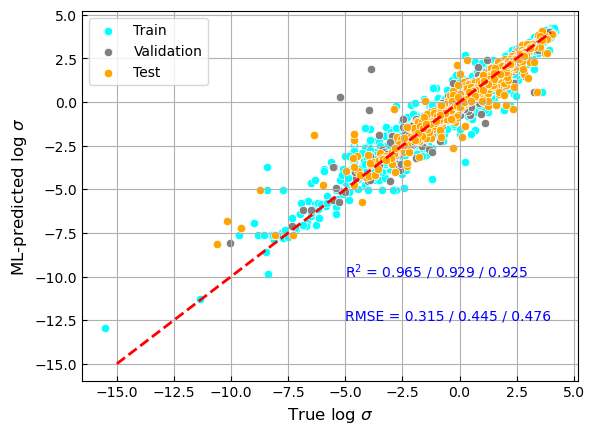

In [20]:
xl = np.arange(-15,5,1)
yl = np.arange(-15,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-5, -12.5, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-5, -10, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_tt.jpg'
# plt.savefig(filename, dpi=300)

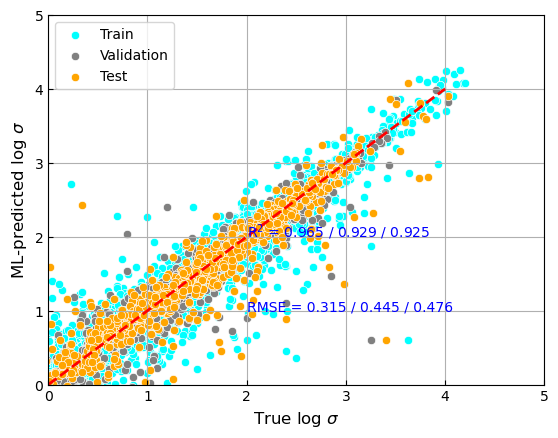

In [21]:
xl = np.arange(0,5,1)
yl = np.arange(0,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.xlim([0,5])
plt.ylim([0,5])
plt.text(2, 1, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(2, 2, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_tt_z.jpg'
# plt.savefig(filename, dpi=300)

**With standardization**

In [22]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

In [23]:
X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [24]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        gbm.fit(X_train_cv, y_train_cv)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_cvs_' + str(10) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [26]:
def read_param(param):
    fname = 'best-paramters_lgbr_cvs_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [27]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

0.00014051507149266424 9.213889300823755e-05 38 402 6 46 0.9040467574928044 0.7895334252037306 1 9 0.12025396605601621 0.1772059693710285 0.6397787807263406


In [28]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.6397787807263406, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.6397787807263406
[LightGBM] [Warning] lambda_l1 is set=0.00014051507149266424, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014051507149266424
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=0.12025396605601621, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.12025396605601621
[LightGBM] [Warning] feature_fraction is set=0.9040467574928044, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9040467574928044
[LightGBM] [Warning] bagging_fraction is set=0.7895334252037306, subsample=1.0 will be ignored. Current value: bagging_fractio

In [29]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

30
Best RMSE for train/val: 0.31861555805194636/0.46045320825482844
Best R2 for train/val: 0.964353268861094/0.9236514380731987


In [30]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [31]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.31861555805194636 / 0.46045320825482844 / 0.4523215792708136
R2 for train / validation / test: 0.964353268861094 / 0.9236514380731987 / 0.9325173809960142


In [23]:
# save_fig_path = '/Users/riteshkumar/Library/CloudStorage/Box-Box/Meetings/Subgroup-meetings/liquid-electrolyte/2022-08-10/'
save_fig_path = os.getcwd()

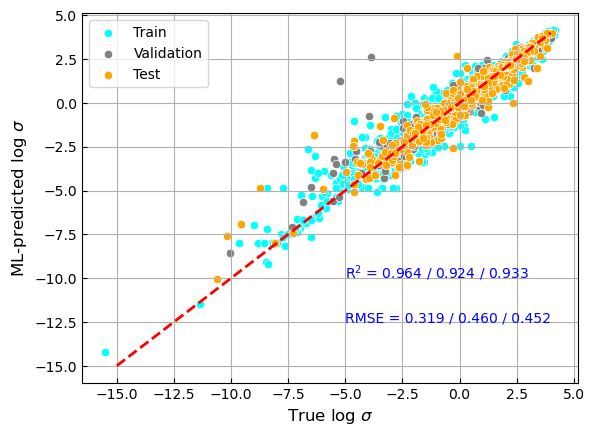

In [32]:
xl = np.arange(-15,5,1)
yl = np.arange(-15,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-5, -12.5, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-5, -10, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1.jpg'
# plt.savefig(filename, dpi=300)

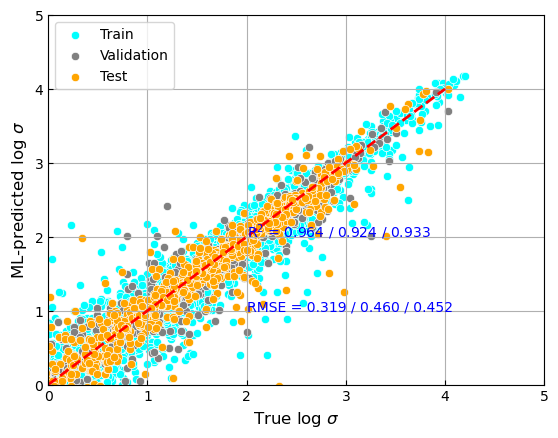

In [33]:
xl = np.arange(0,5,1)
yl = np.arange(0,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.xlim([0,5])
plt.ylim([0,5])
plt.text(2, 1, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(2, 2, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_cv_1_z.jpg'
# plt.savefig(filename, dpi=300)

In [35]:
pickle.dump(model[ind], open('lgbm_cond_multi_random_scaled_3.pkl', 'wb')) ## this model not used

Run again for saving the model

In [ ]:
# p1 = 0.004508517433095906
# p2 = 0.10303649636660432
# p3 = 76
# p4 = 412
# p5 = 6
# p6 = 40
# p7 = 0.9677417596284222
# p8 = 0.5872879721375487
# p9 = 1
# p10 = 8
# p11 = 0.17401196197644608
# p12 = 0.3950672740000618
# p13 = 0.8646042972619387
# params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
#          'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
#          'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
#          'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
#          'min_sum_hessian_in_leaf': p13}

# R2_train_array = []; R2_val_array = []
# rmse_train_array = []; rmse_val_array = []
# model = []
# start = 85
# end = 85
# for i in range(start, end+1):
#     print("counter for cv split: ", i)
#     kf = KFold(n_splits = 5, random_state = i, shuffle = True)
#     lgb = LGBMRegressor(**params)
#     for train_ind, test_ind in kf.split(X_train_):
#         X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
#         X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
#         lgb.fit(X_train_cv, y_train_cv)
#     y_pred_train = lgb.predict(X_train_)
#     y_pred_val = lgb.predict(X_val_)
#     rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
#     rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
#     R2_train = r2_score(y_train, y_pred_train)
#     R2_val = r2_score(y_val, y_pred_val)
#     rmse_train_array.append(rmse_train)
#     rmse_val_array.append(rmse_val)
#     R2_train_array.append(R2_train)
#     R2_val_array.append(R2_val)
#     print(rmse_train, rmse_val)
#     model.append(lgb)

# y_pred_train = model[0].predict(X_train_)
# y_pred_val = model[0].predict(X_val_)
# y_pred_test = model[0].predict(X_test_)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
# R2_test = r2_score(y_test, y_pred_test)

# print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[0], rmse_val_array[0], rmse_test))
# print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[0], R2_val_array[0], R2_test))

In [48]:
# pickle.dump(lgb, open('lgbm_cond_multi_random_scaled_2.pkl', 'wb'))

Without CV on validation

In [36]:
def objective(trial):
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)

    param = {
        "objective": "regression",
        "metric": "root_mean_squared_error",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 100),
        "num_iterations": trial.suggest_int("num_iterations", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "max_bin": trial.suggest_int("max_bin", 2, 50),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 0.9),
        "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 0.1, 0.9)
    }

    gbm = LGBMRegressor(**param)
    gbm.fit(X_train_, y_train)
    # gbm.fit(X_train_, y_train)
    preds = gbm.predict(X_val_)
    score = np.sqrt(mean_squared_error(y_val, preds))
    return score

In [ ]:
fname = 'best-paramters_lgbr_wocv_' + str(10) + '.txt'
f = open(fname, 'w')
f1 = open('best-paramters_lgbr_all.txt', 'a')
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    f.write("  Value: {}\n".format(trial.value))
    f1.write("  Value: {}\n".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 
        f.write("    {}: {}\n".format(key, value))
        f1.write("    {}: {}\n".format(key, value))

f.write("\n")
f1.write("\n")
f.close()
f1.close()

In [38]:
def read_param(param):
    fname = 'best-paramters_lgbr_wocv_' + str(param) + '.txt'
    f0 = open(fname,'r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = float(b[1][1]); p2 = float(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = int(b[5][1]); p6 = int(b[6][1]); p7 = float(b[7][1]); p8 = float(b[8][1])
    p9 = int(b[9][1]); p10 = int(b[10][1]); p11 = float(b[11][1]); p12 = float(b[12][1])
    p13 = float(b[13][1])
    return p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13

In [39]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13 = read_param(10)
params = {"objective": 'regression', "metric": "root_mean_squared_error", "boosting_type": "gbdt", 
# params = {"objective": 'regression', "metric": "root_mean_squared_error", "linear_trees": True, 
         'lambda_l1': p1, 'lambda_l2': p2, 'num_leaves': p3, 'num_iterations': p4, 
         'max_depth': p5, 'max_bin': p6, 'feature_fraction': p7, 'bagging_fraction': p8,
         'bagging_freq': p9, 'min_data_in_leaf': p10, 'min_gain_to_split': p11, 'learning_rate': p12,
         'min_sum_hessian_in_leaf': p13}
print(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13)

0.0010073636544338724 9.827165847041067 20 452 3 41 0.627407263960409 0.8382369376184493 1 9 0.15986671177346395 0.7688547755317213 0.7844630197798843


In [40]:
R2_train_array = []; R2_val_array = []
rmse_train_array = []; rmse_val_array = []
model = []
start = 0
end = 100
for i in range(start, end+1):
    print("counter for cv split: ", i)
    kf = KFold(n_splits = 5, random_state = i, shuffle = True)
    lgb = LGBMRegressor(**params)
    for train_ind, test_ind in kf.split(X_train_):
        X_train_cv, y_train_cv = X_train_[train_ind,:], y_train[train_ind]
        X_test_cv, y_test_cv = X_train_[test_ind,:], y_train[test_ind]
        lgb.fit(X_train_cv, y_train_cv)
    y_pred_train = lgb.predict(X_train_)
    y_pred_val = lgb.predict(X_val_)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    R2_train = r2_score(y_train, y_pred_train)
    R2_val = r2_score(y_val, y_pred_val)
    rmse_train_array.append(rmse_train)
    rmse_val_array.append(rmse_val)
    R2_train_array.append(R2_train)
    R2_val_array.append(R2_val)
    print(rmse_train, rmse_val)
    model.append(lgb)

counter for cv split:  0
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.7844630197798843, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.7844630197798843
[LightGBM] [Warning] lambda_l1 is set=0.0010073636544338724, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010073636544338724
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_gain_to_split is set=0.15986671177346395, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.15986671177346395
[LightGBM] [Warning] feature_fraction is set=0.627407263960409, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.627407263960409
[LightGBM] [Warning] bagging_fraction is set=0.8382369376184493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.

In [41]:
min_rmse = min(rmse_val_array)
ind = rmse_val_array.index(min_rmse)
print(ind)
print("Best RMSE for train/val: {}/{}".format(rmse_train_array[ind], rmse_val_array[ind]))
print("Best R2 for train/val: {}/{}".format(R2_train_array[ind], R2_val_array[ind]))
# print("Best R2 for train: ", R2_train_array[ind])

36
Best RMSE for train/val: 0.3709278421124791/0.47237768615022313
Best R2 for train/val: 0.9516869317668989/0.919645795921358


In [42]:
y_pred_train = model[ind].predict(X_train_)
y_pred_val = model[ind].predict(X_val_)
y_pred_test = model[ind].predict(X_test_)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
R2_test = r2_score(y_test, y_pred_test)

In [43]:
print("RMSE for train / validation / test: {} / {} / {}".format(rmse_train_array[ind], rmse_val_array[ind], rmse_test))
print("R2 for train / validation / test: {} / {} / {}".format(R2_train_array[ind], R2_val_array[ind], R2_test))

RMSE for train / validation / test: 0.3709278421124791 / 0.47237768615022313 / 0.4973194808819298
R2 for train / validation / test: 0.9516869317668989 / 0.919645795921358 / 0.918422900913513


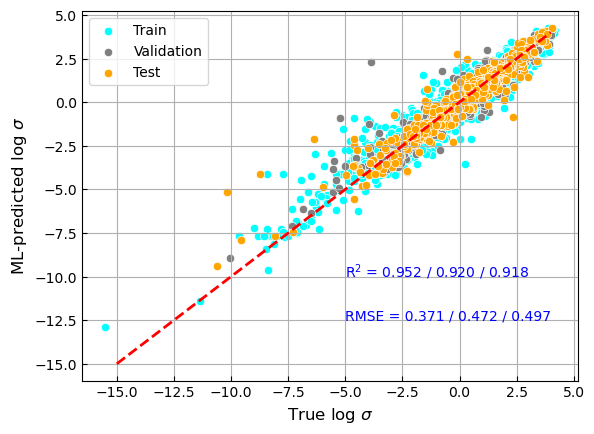

In [44]:
xl = np.arange(-15,5,1)
yl = np.arange(-15,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.text(-5, -12.5, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(-5, -10, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_wocv_1.jpg'
# plt.savefig(filename, dpi=300)

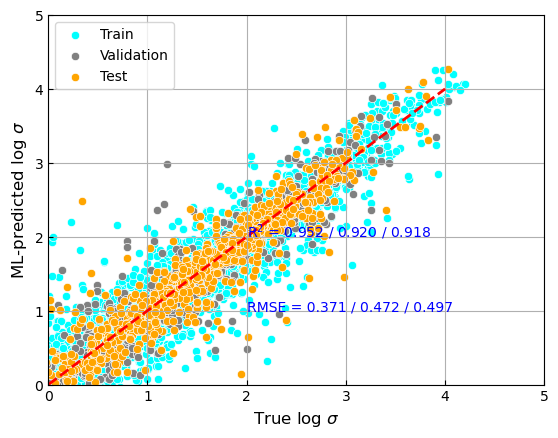

In [45]:
xl = np.arange(0,5,1)
yl = np.arange(0,5,1)
plt.plot(yl, xl, linestyle='dashed', linewidth=2.0, color='red')  

plt.tick_params(axis='both', direction='in')
plt.xlabel('True log $\sigma$',fontsize=12)
plt.ylabel('ML-predicted log $\sigma$',fontsize=12)
sns.scatterplot(x=y_train, y=y_pred_train, color="cyan", label='Train')
sns.scatterplot(x=y_val, y=y_pred_val, color="gray", label='Validation')
sns.scatterplot(x=y_test, y=y_pred_test, color="orange", label='Test')
plt.grid()
plt.xlim([0,5])
plt.ylim([0,5])
plt.text(2, 1, 'RMSE = {:.3f} / {:.3f} / {:.3f}'.format(rmse_train_array[ind], rmse_val_array[ind], rmse_test), color='blue')
plt.text(2, 2, 'R$^2$ = {:.3f} / {:.3f} / {:.3f}'.format(R2_train_array[ind], R2_val_array[ind], R2_test), color='blue')
plt.show()
# filename = save_fig_path + 'fgrp_lgbm_wocv_1_z.jpg'
# plt.savefig(filename, dpi=300)

In [47]:
pickle.dump(model[ind], open('lgbm_cond_multi_random_scaled_32.pkl', 'wb')) ## this model used